In [ ]:
#This Notebook will show training Squeezenet on Pytorch Summary of the notebook

#Training  has THREE parts Optimization of Hyperparameters using Sequential Model Based Optimization (SMBO).
#Fitting the Model with the best hyperparameters obtained from optimization. 
#Testing the Model on test set For optimization: Trained with 15 epochs and patient of 3. 
#Total of 300 trials for looking of best hyperparameters combination. 
#For fitting the Model with best hyperparameters: Trained with 100 epochs and patient of 10.

In [1]:
import os
import torch
import time
import random
import hyperopt
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from hyperopt.pyll.stochastic import sample
from torch.utils.data import DataLoader
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from torch.optim import Adam, SGD, RMSprop
from torchvision.models import mobilenet_v2
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#Checking Training machine
!nvidia-smi

Thu Feb  1 09:38:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:07:00.0 Off |                  N/A |
|  0%   48C    P8              16W / 170W |   7315MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
def get_data_loader(batch_size):
    train_transform = transforms.Compose([  #Train set Transform
        transforms.Resize((128, 128)),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([ #Validation set Transform
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

    #Transform train and validation set
    train_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/train', transform=train_transform)
    val_dataset = ImageFolder(root='/home/g6501222802/thesis/opt_data/val', transform=val_transform)

    #Creating Loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

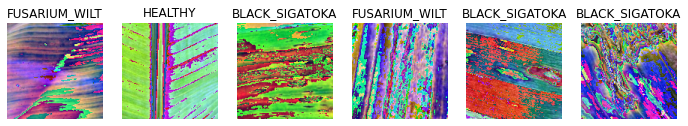

In [4]:
# Print some random images from the dataset
train_transform = transforms.Compose([    # Define data transformations including data augmentation
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder('/home/g6501222802/thesis/opt_data/train', transform=train_transform)
sample_indices = random.sample(range(len(train_dataset)), 6)
sample_images, sample_labels = zip(*[train_dataset[i] for i in sample_indices])
sample_images = [transforms.functional.to_pil_image(img) for img in sample_images]
sample_labels = [train_dataset.classes[label] for label in sample_labels]

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(np.array(sample_images[i]))
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()

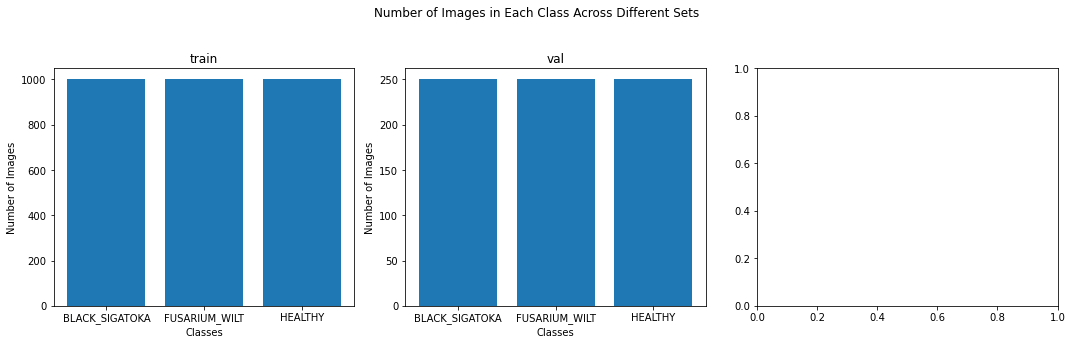

In [7]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.jpg')])

# Main directory path
main_directory_path = '/home/g6501222802/thesis/opt_data'

# Sub-directories
sets = ['train', 'val']
classes = ['BLACK_SIGATOKA', 'FUSARIUM_WILT', 'HEALTHY']

# Dictionary to hold image counts
image_counts = {set_name: {class_name: 0 for class_name in classes} for set_name in sets}

# Counting images in each set and class
for set_name in sets:
    for class_name in classes:
        dir_path = os.path.join(main_directory_path, set_name, class_name)
        image_counts[set_name][class_name] = count_images_in_directory(dir_path)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Number of Images in Each Class Across Different Sets')

for i, set_name in enumerate(sets):
    counts = [image_counts[set_name][class_name] for class_name in classes]
    axs[i].bar(classes, counts)
    axs[i].set_title(set_name)
    axs[i].set_xlabel('Classes')
    axs[i].set_ylabel('Number of Images')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
def reset_globals():

    global train_losses, train_accuracies, val_losses, val_accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
# Call reset_globals before starting the optimization process
reset_globals()

def objective(params, iter_counter):

    global train_losses, train_accuracies, val_losses, val_accuracies
    
    early_stopping = EarlyStopping(patience=5, verbose=True)  #Early stopping

    start_time = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader = get_data_loader(params['batch_size'])
    
   # Load the pre-trained SqueezeNet model
    model = models.squeezenet1_1(pretrained=True)

    # Modify the classifier to have three output classes
    model.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1))
    model.num_classes = 3
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if params['optimizer'] == 'Adam':
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    else:  # RMSprop
        optimizer = RMSprop(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

    epoch_data = []


    for epoch in range(15):

        model.train()
        train_loss =0.0
        train_correct= 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * train_correct / total
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_accuracy)


        # Validation loop
        model.eval()
        val_loss =0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()


        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')
        epoch_data.append([epoch+1, train_accuracy, train_loss, val_accuracy, val_loss])
        
        
        # Check for early stopping
        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

    end_time = time.time()
    iteration_duration = end_time - start_time

    return {
        'loss': val_loss,
        'status': STATUS_OK,
        'val_accuracy': val_accuracy,
        'train_accuracy': train_accuracy,
        'train_loss': train_loss,
        'iteration_time': iteration_duration,
        'iter_counter': iter_counter,
        'params': params
    }

optimizer_choices = {Adam: 'Adam', SGD: 'SGD', RMSprop: 'RMSprop'}

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
    'momentum': hp.uniform('momentum', 0.9, 0.99),
    'batch_size': hp.choice('batch_size', [64, 128, 256]),
    'optimizer': hp.choice('optimizer', [Adam, SGD, RMSprop]),
}

#Run Optimization with 300 trials
trials = Trials()
best = fmin(fn=lambda params: objective(params, len(trials.trials)), space=space, algo=tpe.suggest, max_evals=300, trials=trials)

# Extracting trial data and saving to CSV
results = []
for trial in trials.trials:
    result = trial['result']
    result['params']['optimizer'] = optimizer_choices[result['params']['optimizer']]
    results.append(result)

df = pd.DataFrame(results)
df.to_csv('/home/g6501222802/thesis/results/squeezenet_s1_results.csv', index=False)
print("Best parameters found:", best)


  0%|                                                                 | 0/300 [00:00<?, ?trial/s, best loss=?]

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(

/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1: Train Acc: 79.53%, Train Loss: 24.7362, Val Acc: 70.40%, Val Loss: 12.3791                           
Validation loss decreased (inf --> 1.031595). Saving model...                                                 
Epoch 2: Train Acc: 86.63%, Train Loss: 17.7502, Val Acc: 75.47%, Val Loss: 11.7957                           
Validation loss decreased (1.031595 --> 0.982972). Saving model...                                            
Epoch 3: Train Acc: 92.27%, Train Loss: 10.4909, Val Acc: 84.27%, Val Loss: 11.5449                           
Validation loss decreased (0.982972 --> 0.962078). Saving model...                                            
Epoch 4: Train Acc: 92.63%, Train Loss: 10.8778, Val Acc: 88.13%, Val Loss: 10.7324                           
Validation loss decreased (0.962078 --> 0.894364). Saving model...                                            
Epoch 5: Train Acc: 93.80%, Train Loss: 7.9167, Val Acc: 91.47%, Val Loss: 4.4443                             
V

Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 32.60%, Train Loss: 34940.4373, Val Acc: 33.33%, Val Loss: 3.6233                         
Validation loss decreased (inf --> 1.207770). Saving model...                                                 
Epoch 2: Train Acc: 31.47%, Train Loss: 13.6584, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.207770 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.33%, Train Loss: 13.2248, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.23%, Train Loss: 13.1978, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 15: Train Acc: 33.33%, Train Loss: 51.6453, Val Acc: 33.33%, Val Loss: 13.1833                          
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 34.27%, Train Loss: 2985398562.3761, Val Acc: 33.33%, Val Loss: 13.1833                   
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.33%, Train Loss: 51.6348, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.33%, Train Loss: 51.6348, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Epoch 5: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 7: Train Acc: 33.37%, Train Loss: 26.3654, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 8: Train Acc: 33.33%, Train Loss: 26.3647, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 9: Train Acc: 33.40%, Train Loss: 26.3586, Val Acc: 33.33%, Val Loss: 6.5917                            
V

Epoch 3: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 4: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 5: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 6: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 7: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
V

Validation loss decreased (0.133451 --> 0.123383). Saving model...                                            
Epoch 4: Train Acc: 96.40%, Train Loss: 4.8793, Val Acc: 96.53%, Val Loss: 1.2729                             
Validation loss decreased (0.123383 --> 0.106076). Saving model...                                            
Epoch 5: Train Acc: 97.43%, Train Loss: 3.4265, Val Acc: 96.40%, Val Loss: 1.2175                             
Validation loss decreased (0.106076 --> 0.101459). Saving model...                                            
Epoch 6: Train Acc: 97.43%, Train Loss: 3.3629, Val Acc: 97.20%, Val Loss: 1.1273                             
Validation loss decreased (0.101459 --> 0.093940). Saving model...                                            
Epoch 7: Train Acc: 97.27%, Train Loss: 3.3491, Val Acc: 96.53%, Val Loss: 1.3459                             
EarlyStopping counter: 1 out of 5                                                                             
E

Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.43%, Train Loss: 26.3695, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.43%, Train Loss: 26.3655, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.37%, Train Loss: 26.3656, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.37%, Train Loss: 26.3671, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Epoch 2: Train Acc: 33.97%, Train Loss: 26.4092, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.50%, Train Loss: 26.3722, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.10%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.47%, Train Loss: 26.3669, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.17%, Train Loss: 26.3706, Val Acc: 33.33%, Val Loss: 6.5917                            
V

Epoch 15: Train Acc: 33.13%, Train Loss: 26.3668, Val Acc: 33.33%, Val Loss: 6.5917                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 43.20%, Train Loss: 30.3283, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 58.80%, Train Loss: 22.5523, Val Acc: 47.33%, Val Loss: 6.5515                            
Validation loss decreased (1.098612 --> 1.091924). Saving model...                                            
Epoch 3: Train Acc: 67.00%, Train Loss: 17.0949, Val Acc: 63.07%, Val Loss: 5.2181                            
Validation loss decreased (1.091924 --> 0.869676). Saving model...                                            
Epoch 4: Train Acc: 82.57%, Train Loss: 11.8097, Val Acc: 84.53%, Val Loss: 3.7399                            
V

Validation loss decreased (0.073006 --> 0.068035). Saving model...                                            
Epoch 14: Train Acc: 98.80%, Train Loss: 0.3499, Val Acc: 96.80%, Val Loss: 0.2817                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 15: Train Acc: 98.73%, Train Loss: 0.3653, Val Acc: 97.33%, Val Loss: 0.2193                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 1: Train Acc: 33.70%, Train Loss: 297977949033834.7500, Val Acc: 33.33%, Val Loss: 1549342.8008         
Validation loss decreased (inf --> 516447.600260). Saving model...                                            
Epoch 2: Train Acc: 32.13%, Train Loss: 796640510.7256, Val Acc: 33.33%, Val Loss: 1001.0494                  
Validation loss decreased (516447.600260 --> 333.683142). Saving model...                                     
E

Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 13: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 14: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 15: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 55.63%, Train Loss: 11.2989, Val Acc: 80.80%, Val Loss: 1.6707                            
Validation loss decreased (inf --> 0.556916). Saving model...                                                 
E

Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 11: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 12: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 13: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 14: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 3: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 4: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 5: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 6: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
E

Epoch 9: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 10: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 11: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 12: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 13: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
V

Epoch 7: Train Acc: 96.50%, Train Loss: 1.1518, Val Acc: 94.67%, Val Loss: 0.5817                             
EarlyStopping counter: 2 out of 5                                                                             
Epoch 8: Train Acc: 96.57%, Train Loss: 1.1286, Val Acc: 95.87%, Val Loss: 0.3417                             
Validation loss decreased (0.133770 --> 0.113912). Saving model...                                            
Epoch 9: Train Acc: 97.73%, Train Loss: 0.7908, Val Acc: 96.80%, Val Loss: 0.2901                             
Validation loss decreased (0.113912 --> 0.096706). Saving model...                                            
Epoch 10: Train Acc: 98.07%, Train Loss: 0.7241, Val Acc: 97.07%, Val Loss: 0.2839                            
Validation loss decreased (0.096706 --> 0.094638). Saving model...                                            
Epoch 11: Train Acc: 98.67%, Train Loss: 0.5151, Val Acc: 97.20%, Val Loss: 0.2611                            
V

Epoch 5: Train Acc: 93.27%, Train Loss: 2.4076, Val Acc: 92.00%, Val Loss: 0.9409                             
Validation loss decreased (0.520580 --> 0.313643). Saving model...                                            
Epoch 6: Train Acc: 93.90%, Train Loss: 2.0721, Val Acc: 90.93%, Val Loss: 0.7592                             
Validation loss decreased (0.313643 --> 0.253054). Saving model...                                            
Epoch 7: Train Acc: 95.20%, Train Loss: 1.6527, Val Acc: 95.33%, Val Loss: 0.4802                             
Validation loss decreased (0.253054 --> 0.160082). Saving model...                                            
Epoch 8: Train Acc: 95.63%, Train Loss: 1.4753, Val Acc: 95.87%, Val Loss: 0.4049                             
Validation loss decreased (0.160082 --> 0.134952). Saving model...                                            
Epoch 9: Train Acc: 96.50%, Train Loss: 1.2200, Val Acc: 93.87%, Val Loss: 0.6080                             
E

Epoch 3: Train Acc: 91.93%, Train Loss: 2.7999, Val Acc: 91.47%, Val Loss: 0.6106                             
Validation loss decreased (0.307108 --> 0.203520). Saving model...                                            
Epoch 4: Train Acc: 94.20%, Train Loss: 1.9571, Val Acc: 95.33%, Val Loss: 0.3642                             
Validation loss decreased (0.203520 --> 0.121404). Saving model...                                            
Epoch 5: Train Acc: 95.40%, Train Loss: 1.4683, Val Acc: 96.13%, Val Loss: 0.3736                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 6: Train Acc: 96.67%, Train Loss: 1.2019, Val Acc: 96.40%, Val Loss: 0.3055                             
Validation loss decreased (0.121404 --> 0.101833). Saving model...                                            
Epoch 7: Train Acc: 97.40%, Train Loss: 0.9947, Val Acc: 96.67%, Val Loss: 0.3089                             
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 14: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 15: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 33.50%, Train Loss: 4834.9808, Val Acc: 33.33%, Val Loss: 13.1833                         
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.23%, Train Loss: 51.6352, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.37%, Train Loss: 51.6346, Val Acc: 33.33%, Val Loss: 13.1833                           
V

Epoch 13: Train Acc: 98.77%, Train Loss: 0.4905, Val Acc: 97.47%, Val Loss: 0.3316                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 14: Train Acc: 99.13%, Train Loss: 0.2820, Val Acc: 97.47%, Val Loss: 0.2354                            
Validation loss decreased (0.080149 --> 0.078455). Saving model...                                            
Epoch 15: Train Acc: 99.10%, Train Loss: 0.2714, Val Acc: 97.60%, Val Loss: 0.2747                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 33.67%, Train Loss: 1065936972733.5653, Val Acc: 33.33%, Val Loss: 13.1833                
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.33%, Train Loss: 51.6348, Val Acc: 33.33%, Val Loss: 13.1833                           
V

Epoch 11: Train Acc: 98.23%, Train Loss: 0.6000, Val Acc: 97.07%, Val Loss: 0.2877                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 98.80%, Train Loss: 0.5065, Val Acc: 97.47%, Val Loss: 0.2307                            
Validation loss decreased (0.089996 --> 0.076915). Saving model...                                            
Epoch 13: Train Acc: 98.73%, Train Loss: 0.4332, Val Acc: 97.33%, Val Loss: 0.2604                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 98.90%, Train Loss: 0.3740, Val Acc: 96.53%, Val Loss: 0.2429                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 15: Train Acc: 98.77%, Train Loss: 0.3838, Val Acc: 96.93%, Val Loss: 0.2642                            
E

Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 8: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 9: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 10: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 11: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
E

Validation loss decreased (1.056258 --> 1.002386). Saving model...                                            
Epoch 6: Train Acc: 62.87%, Train Loss: 9.4517, Val Acc: 60.80%, Val Loss: 2.8505                             
Validation loss decreased (1.002386 --> 0.950166). Saving model...                                            
Epoch 7: Train Acc: 70.37%, Train Loss: 8.1810, Val Acc: 69.73%, Val Loss: 2.4010                             
Validation loss decreased (0.950166 --> 0.800321). Saving model...                                            
Epoch 8: Train Acc: 75.77%, Train Loss: 7.0996, Val Acc: 79.20%, Val Loss: 1.6718                             
Validation loss decreased (0.800321 --> 0.557272). Saving model...                                            
Epoch 9: Train Acc: 78.60%, Train Loss: 6.1403, Val Acc: 82.27%, Val Loss: 1.4258                             
Validation loss decreased (0.557272 --> 0.475259). Saving model...                                            
E

Validation loss decreased (0.324380 --> 0.169306). Saving model...                                            
Epoch 4: Train Acc: 94.27%, Train Loss: 3.9447, Val Acc: 94.27%, Val Loss: 0.9987                             
Validation loss decreased (0.169306 --> 0.166450). Saving model...                                            
Epoch 5: Train Acc: 94.93%, Train Loss: 3.2466, Val Acc: 94.67%, Val Loss: 0.9450                             
Validation loss decreased (0.166450 --> 0.157496). Saving model...                                            
Epoch 6: Train Acc: 96.57%, Train Loss: 2.4310, Val Acc: 95.33%, Val Loss: 0.8164                             
Validation loss decreased (0.157496 --> 0.136064). Saving model...                                            
Epoch 7: Train Acc: 96.73%, Train Loss: 2.2460, Val Acc: 95.47%, Val Loss: 0.6924                             
Validation loss decreased (0.136064 --> 0.115402). Saving model...                                            
E

Epoch 3: Train Acc: 78.57%, Train Loss: 6.6627, Val Acc: 78.13%, Val Loss: 2.0854                             
Validation loss decreased (0.942701 --> 0.695128). Saving model...                                            
Epoch 4: Train Acc: 83.60%, Train Loss: 5.2377, Val Acc: 87.20%, Val Loss: 1.0532                             
Validation loss decreased (0.695128 --> 0.351082). Saving model...                                            
Epoch 5: Train Acc: 90.90%, Train Loss: 3.1008, Val Acc: 92.27%, Val Loss: 0.7077                             
Validation loss decreased (0.351082 --> 0.235907). Saving model...                                            
Epoch 6: Train Acc: 91.60%, Train Loss: 2.8976, Val Acc: 91.47%, Val Loss: 0.8175                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 7: Train Acc: 93.70%, Train Loss: 2.0545, Val Acc: 94.40%, Val Loss: 0.5165                             
V

EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 96.53%, Train Loss: 1.1702, Val Acc: 94.80%, Val Loss: 0.4772                            
Validation loss decreased (0.164510 --> 0.159064). Saving model...                                            
Epoch 11: Train Acc: 96.23%, Train Loss: 1.3394, Val Acc: 95.73%, Val Loss: 0.4381                            
Validation loss decreased (0.159064 --> 0.146033). Saving model...                                            
Epoch 12: Train Acc: 96.63%, Train Loss: 1.0834, Val Acc: 95.60%, Val Loss: 0.4297                            
Validation loss decreased (0.146033 --> 0.143241). Saving model...                                            
Epoch 13: Train Acc: 96.83%, Train Loss: 1.0570, Val Acc: 93.47%, Val Loss: 0.6367                            
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 8: Train Acc: 98.17%, Train Loss: 0.5728, Val Acc: 97.73%, Val Loss: 0.2355                             
Validation loss decreased (0.079058 --> 0.078488). Saving model...                                            
Epoch 9: Train Acc: 98.57%, Train Loss: 0.5296, Val Acc: 97.33%, Val Loss: 0.2394                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 98.70%, Train Loss: 0.3944, Val Acc: 98.00%, Val Loss: 0.1757                            
Validation loss decreased (0.078488 --> 0.058580). Saving model...                                            
Epoch 11: Train Acc: 99.20%, Train Loss: 0.3208, Val Acc: 98.13%, Val Loss: 0.1905                            
EarlyStopping counter: 1 out of 5                                                                             
E

Epoch 7: Train Acc: 33.33%, Train Loss: 13.1815, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 8: Train Acc: 33.33%, Train Loss: 13.1894, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 9: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 10: Train Acc: 33.33%, Train Loss: 13.1796, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 11: Train Acc: 33.33%, Train Loss: 13.1842, Val Acc: 33.33%, Val Loss: 3.2958                           
V

Epoch 5: Train Acc: 33.37%, Train Loss: 51.6360, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.27%, Train Loss: 51.6377, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 7: Train Acc: 33.37%, Train Loss: 51.6346, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 8: Train Acc: 33.30%, Train Loss: 51.6349, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 9: Train Acc: 33.30%, Train Loss: 51.6337, Val Acc: 33.33%, Val Loss: 13.1833                           
V

Epoch 3: Train Acc: 33.30%, Train Loss: 26.5250, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 7: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                            
V

Epoch 1: Train Acc: 34.50%, Train Loss: 461834874.6697, Val Acc: 33.33%, Val Loss: 3.2958                     
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.33%, Train Loss: 13.1867, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.33%, Train Loss: 13.1848, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.33%, Train Loss: 13.1834, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.33%, Train Loss: 13.1834, Val Acc: 33.33%, Val Loss: 3.2958                            
V

Epoch 14: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 15: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 48.13%, Train Loss: 14.0692, Val Acc: 44.00%, Val Loss: 3.1910                            
Validation loss decreased (inf --> 1.063680). Saving model...                                                 
Epoch 2: Train Acc: 56.37%, Train Loss: 12.6511, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 68.87%, Train Loss: 9.4096, Val Acc: 46.13%, Val Loss: 3.1864                             
V

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 12: Train Acc: 33.33%, Train Loss: 13.1833, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 13: Train Acc: 33.33%, Train Loss: 13.1831, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 14: Train Acc: 33.30%, Train Loss: 13.1830, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 15: Train Acc: 33.33%, Train Loss: 13.1835, Val Acc: 33.33%, Val Loss: 3.2958                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 1: Train Acc: 32.77%, Train Loss: 128308380453677257523908099178496.0000, Val Acc: 33.33%, Val Loss: 34211

EarlyStopping counter: 2 out of 5                                                                             
Epoch 10: Train Acc: 98.50%, Train Loss: 0.4903, Val Acc: 96.93%, Val Loss: 0.2533                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 11: Train Acc: 99.03%, Train Loss: 0.3737, Val Acc: 97.87%, Val Loss: 0.2453                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 12: Train Acc: 99.40%, Train Loss: 0.2780, Val Acc: 98.27%, Val Loss: 0.2303                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 33.83%, Train Loss: 76.0048, Val Acc: 33.33%, Val Loss: 13.1833                           
V

Epoch 10: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 11: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 12: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 13: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 14: Train Acc: 33.33%, Train Loss: 26.3667, Val Acc: 33.33%, Val Loss: 6.5917                           
V

Validation loss decreased (0.075482 --> 0.070401). Saving model...                                            
Epoch 9: Train Acc: 98.60%, Train Loss: 0.4442, Val Acc: 97.07%, Val Loss: 0.2106                             
Validation loss decreased (0.070401 --> 0.070192). Saving model...                                            
Epoch 10: Train Acc: 99.07%, Train Loss: 0.3284, Val Acc: 97.47%, Val Loss: 0.2184                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 99.07%, Train Loss: 0.2939, Val Acc: 96.53%, Val Loss: 0.2445                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 99.23%, Train Loss: 0.2447, Val Acc: 97.33%, Val Loss: 0.2024                            
Validation loss decreased (0.070192 --> 0.067477). Saving model...                                            
E

Epoch 11: Train Acc: 97.80%, Train Loss: 0.7193, Val Acc: 96.80%, Val Loss: 0.3357                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 98.27%, Train Loss: 0.5597, Val Acc: 96.93%, Val Loss: 0.2996                            
Validation loss decreased (0.105148 --> 0.099879). Saving model...                                            
Epoch 13: Train Acc: 98.50%, Train Loss: 0.4150, Val Acc: 97.33%, Val Loss: 0.3345                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 15: Train Acc: 98.37%, Train Loss: 0.5278, Val Acc: 97.47%, Val Loss: 0.4344                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 1: Train Acc: 70.30%, Train Loss: 11.5904, Val Acc: 81.33%, Val Loss: 2.4965                            
V

Epoch 4: Train Acc: 33.50%, Train Loss: 12.6953, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 5: Train Acc: 33.37%, Train Loss: 13.1823, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 6: Train Acc: 33.33%, Train Loss: 13.1885, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 5 out of 5                                                                             
Early stopping                                                                                                
Epoch 1: Train Acc: 75.93%, Train Loss: 6.7539, Val Acc: 90.80%, Val Loss: 0.7602                             
Validation loss decreased (inf --> 0.253384). Saving model...                                                 
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 13: Train Acc: 99.23%, Train Loss: 0.2870, Val Acc: 98.00%, Val Loss: 0.1632                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 14: Train Acc: 99.30%, Train Loss: 0.2274, Val Acc: 98.27%, Val Loss: 0.1552                            
Validation loss decreased (0.053925 --> 0.051737). Saving model...                                            
Epoch 15: Train Acc: 99.30%, Train Loss: 0.2350, Val Acc: 97.87%, Val Loss: 0.1665                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 68.80%, Train Loss: 8.5772, Val Acc: 84.40%, Val Loss: 1.6320                             
Validation loss decreased (inf --> 0.543991). Saving model...                                                 
E

Validation loss decreased (0.134091 --> 0.109636). Saving model...                                            
Epoch 11: Train Acc: 96.97%, Train Loss: 1.1186, Val Acc: 93.60%, Val Loss: 0.5631                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 12: Train Acc: 95.67%, Train Loss: 1.5125, Val Acc: 96.27%, Val Loss: 0.3388                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 13: Train Acc: 96.43%, Train Loss: 1.3031, Val Acc: 96.53%, Val Loss: 0.3157                            
Validation loss decreased (0.109636 --> 0.105230). Saving model...                                            
Epoch 14: Train Acc: 96.77%, Train Loss: 1.2401, Val Acc: 95.87%, Val Loss: 0.3744                            
EarlyStopping counter: 1 out of 5                                                                             
E

Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 3: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 4: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 5: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 6: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
E

Epoch 2: Train Acc: 33.27%, Train Loss: 13.2160, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 33.37%, Train Loss: 13.1800, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.27%, Train Loss: 13.2322, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.33%, Train Loss: 13.1896, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 6: Train Acc: 33.33%, Train Loss: 13.1841, Val Acc: 33.33%, Val Loss: 3.2958                            
V

Epoch 10: Train Acc: 94.80%, Train Loss: 1.8152, Val Acc: 92.93%, Val Loss: 0.7703                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 11: Train Acc: 95.50%, Train Loss: 1.6070, Val Acc: 92.13%, Val Loss: 0.7751                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 12: Train Acc: 96.30%, Train Loss: 1.2783, Val Acc: 96.67%, Val Loss: 0.3713                            
Validation loss decreased (0.243636 --> 0.123779). Saving model...                                            
Epoch 13: Train Acc: 96.97%, Train Loss: 1.1234, Val Acc: 95.47%, Val Loss: 0.4617                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 14: Train Acc: 96.97%, Train Loss: 0.9860, Val Acc: 96.00%, Val Loss: 0.3309                            
V

Epoch 8: Train Acc: 96.70%, Train Loss: 1.1230, Val Acc: 96.27%, Val Loss: 0.3081                             
Validation loss decreased (0.129752 --> 0.102691). Saving model...                                            
Epoch 9: Train Acc: 97.30%, Train Loss: 0.9784, Val Acc: 96.40%, Val Loss: 0.3522                             
EarlyStopping counter: 1 out of 5                                                                             
Epoch 10: Train Acc: 98.17%, Train Loss: 0.7016, Val Acc: 95.87%, Val Loss: 0.3511                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 11: Train Acc: 97.87%, Train Loss: 0.7213, Val Acc: 97.07%, Val Loss: 0.2521                            
Validation loss decreased (0.102691 --> 0.084048). Saving model...                                            
Epoch 12: Train Acc: 98.60%, Train Loss: 0.4790, Val Acc: 97.33%, Val Loss: 0.2385                            
V

Validation loss decreased (0.518771 --> 0.505937). Saving model...                                            
Epoch 14: Train Acc: 78.47%, Train Loss: 5.8696, Val Acc: 90.93%, Val Loss: 1.0802                            
Validation loss decreased (0.505937 --> 0.360076). Saving model...                                            
Epoch 15: Train Acc: 88.33%, Train Loss: 4.0517, Val Acc: 86.93%, Val Loss: 1.7258                            
EarlyStopping counter: 1 out of 5                                                                             
Epoch 1: Train Acc: 33.47%, Train Loss: 5233569.8863, Val Acc: 33.33%, Val Loss: 13.1833                      
Validation loss decreased (inf --> 1.098612). Saving model...                                                 
Epoch 2: Train Acc: 33.33%, Train Loss: 51.6348, Val Acc: 33.33%, Val Loss: 13.1833                           
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 33.63%, Train Loss: 12.5064, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 5: Train Acc: 33.27%, Train Loss: 12.0612, Val Acc: 33.33%, Val Loss: 3.2716                            
Validation loss decreased (1.098580 --> 1.090531). Saving model...                                            
Epoch 6: Train Acc: 33.53%, Train Loss: 11.3300, Val Acc: 33.33%, Val Loss: 2.9799                            
Validation loss decreased (1.090531 --> 0.993293). Saving model...                                            
Epoch 7: Train Acc: 33.60%, Train Loss: 10.4805, Val Acc: 33.33%, Val Loss: 2.5782                            
Validation loss decreased (0.993293 --> 0.859408). Saving model...                                            
E

Epoch 1: Train Acc: 64.17%, Train Loss: 10.8846, Val Acc: 86.00%, Val Loss: 1.0491                            
Validation loss decreased (inf --> 0.349701). Saving model...                                                 
Epoch 2: Train Acc: 87.13%, Train Loss: 4.3812, Val Acc: 90.53%, Val Loss: 0.6851                             
Validation loss decreased (0.349701 --> 0.228356). Saving model...                                            
Epoch 3: Train Acc: 91.90%, Train Loss: 2.5149, Val Acc: 93.47%, Val Loss: 0.4630                             
Validation loss decreased (0.228356 --> 0.154328). Saving model...                                            
Epoch 4: Train Acc: 94.60%, Train Loss: 1.6712, Val Acc: 95.07%, Val Loss: 0.3916                             
Validation loss decreased (0.154328 --> 0.130530). Saving model...                                            
Epoch 5: Train Acc: 95.10%, Train Loss: 1.3941, Val Acc: 94.40%, Val Loss: 0.5069                             
E

Epoch 14: Train Acc: 99.23%, Train Loss: 0.2390, Val Acc: 97.20%, Val Loss: 0.2117                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 15: Train Acc: 99.57%, Train Loss: 0.2211, Val Acc: 97.73%, Val Loss: 0.2437                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 1: Train Acc: 33.30%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (inf --> nan). Saving model...                                                      
Epoch 2: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 3: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
V

Validation loss decreased (0.144376 --> 0.124754). Saving model...                                            
Epoch 6: Train Acc: 96.07%, Train Loss: 2.3118, Val Acc: 95.87%, Val Loss: 0.7396                             
Validation loss decreased (0.124754 --> 0.123264). Saving model...                                            
Epoch 7: Train Acc: 97.60%, Train Loss: 1.7187, Val Acc: 96.00%, Val Loss: 0.6726                             
Validation loss decreased (0.123264 --> 0.112094). Saving model...                                            
Epoch 8: Train Acc: 98.23%, Train Loss: 1.2034, Val Acc: 96.93%, Val Loss: 0.5558                             
Validation loss decreased (0.112094 --> 0.092635). Saving model...                                            
Epoch 9: Train Acc: 98.53%, Train Loss: 1.0931, Val Acc: 96.93%, Val Loss: 0.5737                             
EarlyStopping counter: 1 out of 5                                                                             
E

EarlyStopping counter: 1 out of 5                                                                             
Epoch 3: Train Acc: 33.47%, Train Loss: 13.2595, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 2 out of 5                                                                             
Epoch 4: Train Acc: 33.33%, Train Loss: 13.1883, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 3 out of 5                                                                             
Epoch 5: Train Acc: 33.33%, Train Loss: 13.1854, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 4 out of 5                                                                             
Epoch 6: Train Acc: 33.33%, Train Loss: 13.1792, Val Acc: 33.33%, Val Loss: 3.2958                            
EarlyStopping counter: 5 out of 5                                                                             
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2: Train Acc: 87.43%, Train Loss: 3.8731, Val Acc: 89.87%, Val Loss: 0.9761                             
Validation loss decreased (0.433373 --> 0.325361). Saving model...                                            
Epoch 3: Train Acc: 92.10%, Train Loss: 2.4697, Val Acc: 92.93%, Val Loss: 0.6608                             
Validation loss decreased (0.325361 --> 0.220274). Saving model...                                            
Epoch 4: Train Acc: 94.20%, Train Loss: 2.0981, Val Acc: 94.93%, Val Loss: 0.4463                             
Validation loss decreased (0.220274 --> 0.148758). Saving model...                                            
Epoch 5: Train Acc: 95.27%, Train Loss: 1.5911, Val Acc: 95.87%, Val Loss: 0.3695                             
Validation loss decreased (0.148758 --> 0.123172). Saving model...                                            
Epoch 6: Train Acc: 96.00%, Train Loss: 1.1954, Val Acc: 95.33%, Val Loss: 0.4271                             
E

Validation loss decreased (inf --> 1.153536). Saving model...                                                 
Epoch 2: Train Acc: 35.90%, Train Loss: 17.3725, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.153536 --> 1.098612). Saving model...                                            
Epoch 3: Train Acc: 32.83%, Train Loss: 13.4379, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 4: Train Acc: 33.23%, Train Loss: 13.2474, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
Epoch 5: Train Acc: 33.33%, Train Loss: 13.1854, Val Acc: 33.33%, Val Loss: 3.2958                            
Validation loss decreased (1.098612 --> 1.098612). Saving model...                                            
E

Epoch 8: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 9: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                   
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 10: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 11: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
Validation loss decreased (nan --> nan). Saving model...                                                      
Epoch 12: Train Acc: 33.33%, Train Loss: nan, Val Acc: 33.33%, Val Loss: nan                                  
V

In [2]:
# Define data transformations including data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Define data paths
train_data_path = '/home/g6501222802/thesis/Data/train'
valid_data_path = '/home/g6501222802/thesis/Data/val/'
test_data_path = '/home/g6501222802/thesis/Data/test/'

In [4]:
# Create data loaders
train_dataset = ImageFolder(train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

valid_dataset = ImageFolder(valid_data_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)

test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [6]:
# Load the pre-trained SqueezeNet model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.squeezenet1_1(pretrained=True)
# Modify the classifier to have three output classes
model.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1))
model.num_classes = 3
model = model.to(device)

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0000102, momentum=0.9)

In [8]:
# Define call back for early Stopping Callback
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='/home/g6501222802/thesis/results/squeezenet_s1_best_model_checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [9]:
best_valid_loss = float('inf') 

# Training loop with early stopping
import time
start_time = time.time()
num_epochs = 100 # Adjust the number of epochs as needed


train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
    valid_accuracy.append(100 * correct_valid / total_valid)
    valid_losses.append(valid_loss / len(valid_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracy[-1]:.2f}%, "
          f"Valid Loss: {valid_losses[-1]:.4f}, "
          f"Valid Acc: {valid_accuracy[-1]:.2f}%")
    
      # Save model if validation loss has decreased
    if valid_losses[-1] < best_valid_loss:
        best_valid_loss = valid_losses[-1]
        torch.save(model.state_dict(), '/home/g6501222802/thesis/results/squeezenet_s1_best_model_checkpoint.pt')

    # Check for early stopping
    early_stopping(valid_losses[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model checkpoint
model.load_state_dict(torch.load('/home/g6501222802/thesis/results/squeezenet_s1_best_model_checkpoint.pt'))

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/100, Train Loss: 1.3707, Train Acc: 35.22%, Valid Loss: 0.9647, Valid Acc: 52.43%
Validation loss decreased (inf --> 0.964710). Saving model...
Epoch 2/100, Train Loss: 0.8444, Train Acc: 62.73%, Valid Loss: 0.7187, Valid Acc: 73.20%
Validation loss decreased (0.964710 --> 0.718704). Saving model...
Epoch 3/100, Train Loss: 0.6187, Train Acc: 77.37%, Valid Loss: 0.5174, Valid Acc: 82.64%
Validation loss decreased (0.718704 --> 0.517384). Saving model...
Epoch 4/100, Train Loss: 0.4566, Train Acc: 83.93%, Valid Loss: 0.3749, Valid Acc: 87.51%
Validation loss decreased (0.517384 --> 0.374925). Saving model...
Epoch 5/100, Train Loss: 0.3580, Train Acc: 87.33%, Valid Loss: 0.3021, Valid Acc: 89.44%
Validation loss decreased (0.374925 --> 0.302141). Saving model...
Epoch 6/100, Train Loss: 0.3028, Train Acc: 89.12%, Valid Loss: 0.2632, Valid Acc: 90.79%
Validation loss decreased (0.302141 --> 0.263208). Saving model...
Epoch 7/100, Train Loss: 0.2734, Train Acc: 89.69%, Valid Loss:

Epoch 56/100, Train Loss: 0.0832, Train Acc: 97.16%, Valid Loss: 0.0883, Valid Acc: 96.83%
Validation loss decreased (0.089572 --> 0.088295). Saving model...
Epoch 57/100, Train Loss: 0.0808, Train Acc: 97.02%, Valid Loss: 0.0889, Valid Acc: 97.07%
EarlyStopping counter: 1 out of 10
Epoch 58/100, Train Loss: 0.0837, Train Acc: 96.94%, Valid Loss: 0.0869, Valid Acc: 96.89%
Validation loss decreased (0.088295 --> 0.086943). Saving model...
Epoch 59/100, Train Loss: 0.0791, Train Acc: 96.95%, Valid Loss: 0.0865, Valid Acc: 96.95%
Validation loss decreased (0.086943 --> 0.086469). Saving model...
Epoch 60/100, Train Loss: 0.0797, Train Acc: 97.06%, Valid Loss: 0.0864, Valid Acc: 97.01%
Validation loss decreased (0.086469 --> 0.086351). Saving model...
Epoch 61/100, Train Loss: 0.0789, Train Acc: 97.15%, Valid Loss: 0.0861, Valid Acc: 97.01%
Validation loss decreased (0.086351 --> 0.086098). Saving model...
Epoch 62/100, Train Loss: 0.0780, Train Acc: 97.06%, Valid Loss: 0.0855, Valid Acc: 

In [12]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure both inputs and labels are on the same device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for consistency
        test_labels.extend(labels.cpu().numpy())  # Move labels to CPU for consistency

test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0936
Test Accuracy: 97.06%


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.7f}")

# Calculate precision, recall, and F1 scores
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Precision: {precision:.7f}")
print(f"Recall: {recall:.7f}")
print(f"F1 Score: {f1:.7f}")

Test Accuracy: 0.9705797
Precision: 0.9706846
Recall: 0.9705797
F1 Score: 0.9706070


In [14]:
# Print classification report
class_names = test_dataset.classes
classification_rep = classification_report(test_labels, test_preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
                precision    recall  f1-score   support

BLACK_SIGATOKA       0.97      0.96      0.96      1154
 FUSARIUM_WILT       0.95      0.96      0.96      1152
       HEALTHY       0.99      0.99      0.99      1127

      accuracy                           0.97      3433
     macro avg       0.97      0.97      0.97      3433
  weighted avg       0.97      0.97      0.97      3433



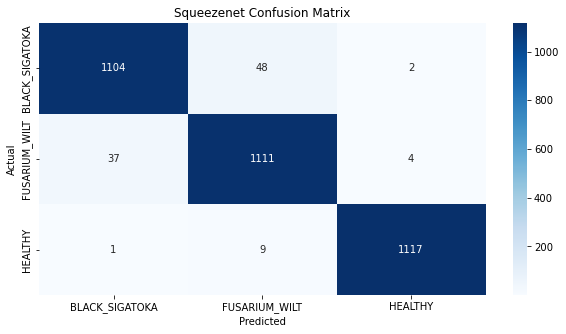

In [15]:
 # Calculate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a heatmap with seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Squeezenet Conf Matrix')
plt.show()

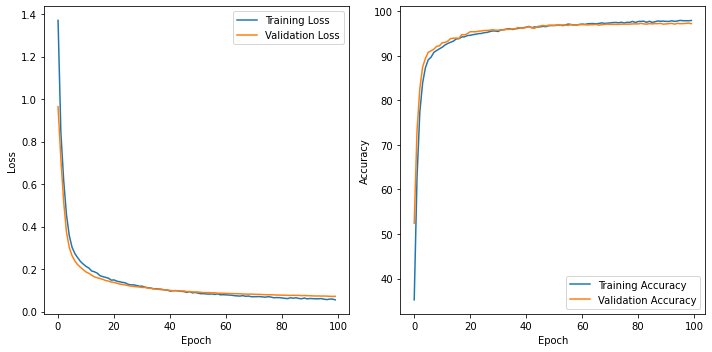

In [16]:
# Plot loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

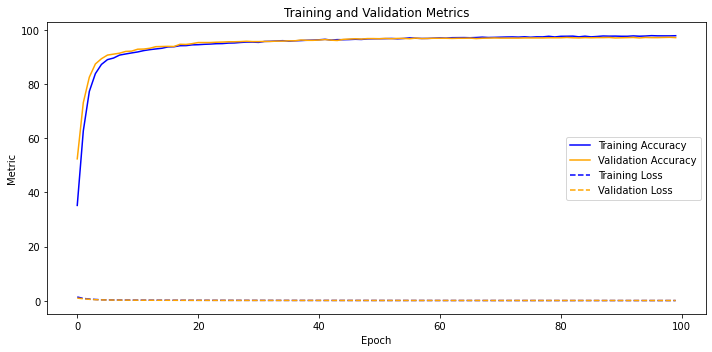

In [17]:
# Plot loss and accuracy graphs on a single set of axes
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(valid_accuracy, label='Validation Accuracy', color='orange')

# Plot Loss
plt.plot(train_losses, label='Training Loss', linestyle='--', color='blue')
plt.plot(valid_losses, label='Validation Loss', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()

In [ ]:
Hyperparameters analysis

/tmp/ipykernel_156729/1338192591.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);


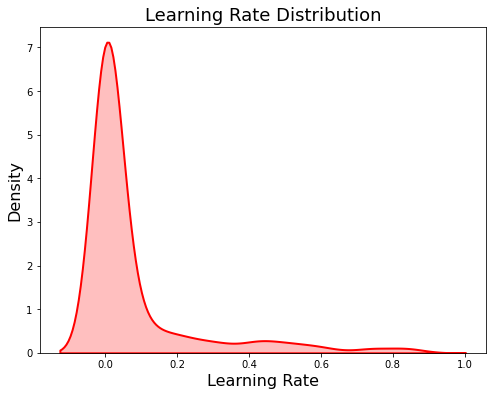

In [19]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.9))}
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(1000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18);
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

/tmp/ipykernel_156729/1388958067.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);


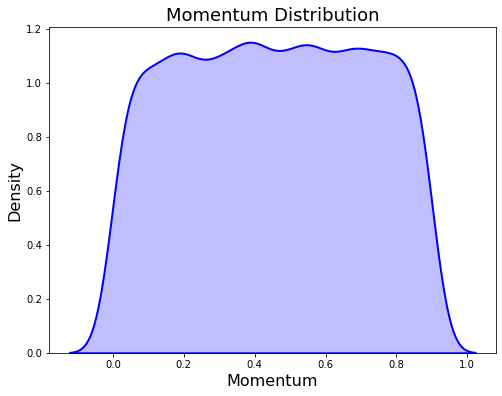

In [20]:
momentum = {'momentum': hp.uniform('momentum', 0.0, 0.9)}
momentum_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    momentum_dist.append(sample(momentum)['momentum'])

plt.figure(figsize = (8, 6))
sns.kdeplot(momentum_dist, color = 'blue', linewidth = 2, shade = True);
plt.title('Momentum Distribution', size = 18);
plt.xlabel('Momentum', size = 16); plt.ylabel('Density', size = 16);

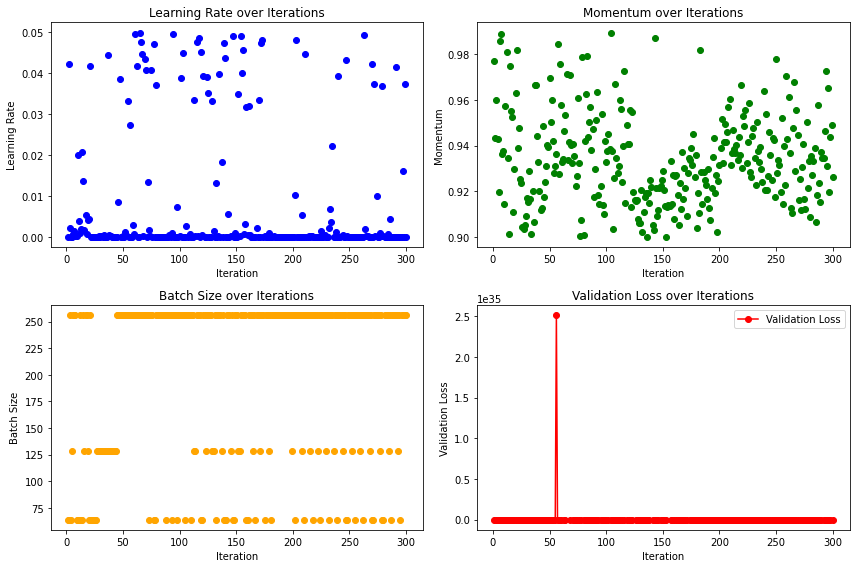

In [22]:
import ast
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/squeezenet_s1_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

iterations = np.array(results_df['iter_counter'])
loss = np.array(results_df['loss'])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for learning rate
axs[0, 0].scatter(iterations, results_df['params'].apply(lambda x: x['learning_rate']),  color='blue', marker='o', label='Learning Rate')

# Scatter plot for momentum
axs[0, 1].scatter(iterations, results_df['params'].apply(lambda x: x['momentum']),  color='green', marker='o', label='Momentum')

# Scatter plot for batch size
axs[1, 0].scatter(iterations, results_df['params'].apply(lambda x: x['batch_size']),  color='orange', marker='o', label='Batch Size')

# Line chart for objective values (e.g., validation loss) over iterations
axs[1, 1].plot(iterations, loss,  color='red', marker='o', label='Validation Loss')

# Set titles and labels for all subplots
axs[0, 0].set_title('Learning Rate over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Learning Rate')

axs[0, 1].set_title('Momentum over Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Momentum')

axs[1, 0].set_title('Batch Size over Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Batch Size')

axs[1, 1].set_title('Validation Loss over Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Validation Loss')

# Display a combined legend for all subplots
plt.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

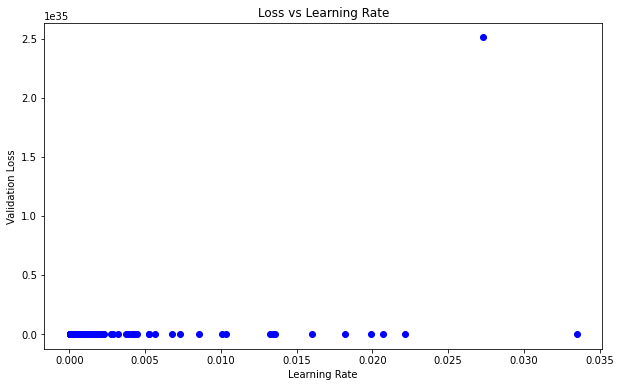

In [23]:
# Load the optimization results from the CSV file
results_df = pd.read_csv('/home/g6501222802/thesis/results/squeezenet_s1_results.csv')

# Convert the 'params' column from string to dictionary
results_df['params'] = results_df['params'].apply(ast.literal_eval)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Create a scatter plot for loss against learning_rate
plt.scatter(results_df['params'].apply(lambda x: x['learning_rate']), results_df['loss'], color='blue', marker='o')
plt.title('Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')

# Show the plot
plt.show()

In [18]:
#COunting the number of parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = models.squeezenet1_1(pretrained=True)  # Pre-trained Mobilenetv2

total_params, trainable_params = count_parameters(model)
print(f'Total Parameters: {total_params}')
print(f'Trainable Parameters: {trainable_params}')

Total Parameters: 1235496
Trainable Parameters: 1235496


/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/g6501222802/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
#Model Size Check
def model_size_in_memory(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    size_in_mb = param_size / (1024 ** 2)  # Convert to megabytes
    return size_in_mb

size_in_mb = model_size_in_memory(model)
print(f'Approximate Model Size in Memory: {size_in_mb:.2f} MB')

Approximate Model Size in Memory: 4.71 MB
